In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
# Загрузка датасета
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
trainset = datasets.MNIST('MNIST\TRAIN', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST\TEST', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
# Создание модели: вход 784 (28х28) -> 128 -> 64 -> 10 (выход т.к. всего 10 цифр) активация ReLU.
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

In [5]:
# Перенос модели по возможности в Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)
model.to(device)

Используемое устройство: cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [7]:
print('До: \n', model[0].weight.grad)

loss.backward()

print('После: \n', model[0].weight.grad)

До: 
 None
После: 
 tensor([[-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        ...,
        [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008]],
       device='cuda:0')


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Начальные веса - ', model[0].weight)
images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Очистка градиента
optimizer.zero_grad()
output = model(images.cuda())
loss = criterion(output, labels.cuda())
loss.backward()
print('Градиент -', model[0].weight.grad)

Начальные веса -  Parameter containing:
tensor([[-0.0322, -0.0034,  0.0125,  ..., -0.0281, -0.0129,  0.0074],
        [ 0.0313,  0.0292,  0.0336,  ..., -0.0049, -0.0312,  0.0357],
        [ 0.0297,  0.0247, -0.0270,  ..., -0.0041,  0.0036,  0.0117],
        ...,
        [ 0.0059, -0.0156, -0.0123,  ..., -0.0101,  0.0050, -0.0127],
        [ 0.0044, -0.0338, -0.0286,  ...,  0.0056, -0.0234,  0.0200],
        [ 0.0009,  0.0024, -0.0292,  ...,  0.0127,  0.0264,  0.0125]],
       device='cuda:0', requires_grad=True)
Градиент - tensor([[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0016, -0.0016, -0.0016,  ..., -0.0016, -0.0016, -0.0016],
        ...,
        [-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007]],
       device='cuda:0')


In [9]:
# Обучение модели
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# После 17 эпох риск переобучения возрастает
epochs = 17
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        loss.backward()
        # Оптимизация весов
        optimizer.step()        
        running_loss += loss.item()
    else:
        print("Эпоха {} - Потери: {}".format(e, running_loss/len(trainloader)))
    
# Тест модели
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img.cuda())

    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("\nПротестировано изображений:", all_count)
print("\nТочность модели:", (correct_count/all_count))

Эпоха 0 - Потери: 0.6584538724392589
Эпоха 1 - Потери: 0.2811424090250977
Эпоха 2 - Потери: 0.21672816311658571
Эпоха 3 - Потери: 0.17806888055969786
Эпоха 4 - Потери: 0.14945913403670288
Эпоха 5 - Потери: 0.13049896989168644
Эпоха 6 - Потери: 0.11405162384380092
Эпоха 7 - Потери: 0.10220504359705553
Эпоха 8 - Потери: 0.09012732848024635
Эпоха 9 - Потери: 0.08255918890233836
Эпоха 10 - Потери: 0.07518310931378178
Эпоха 11 - Потери: 0.06898582596252405
Эпоха 12 - Потери: 0.06310270840986205
Эпоха 13 - Потери: 0.05759478728326637
Эпоха 14 - Потери: 0.05410718841816801
Эпоха 15 - Потери: 0.04971315821896849
Эпоха 16 - Потери: 0.046193120087425446

Протестировано изображений: 10000

Точность модели: 0.9765


Прогнозируемая цифра: 3


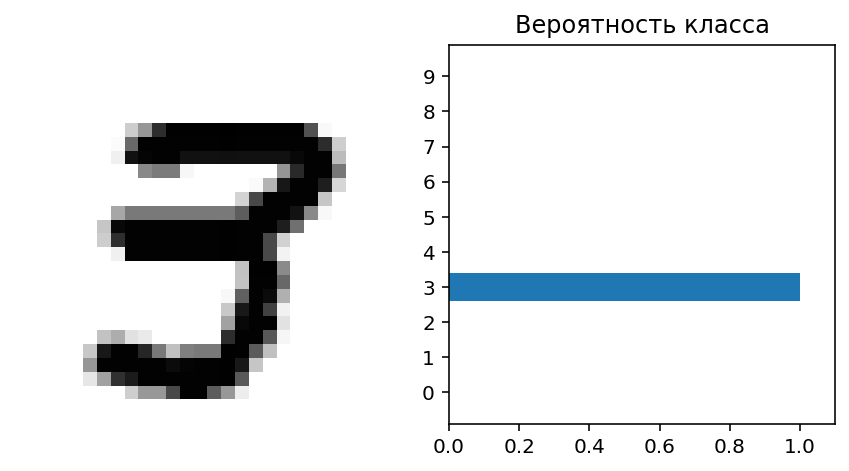

In [10]:
# Функция для вывода классификации
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Вероятность класса')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    
# Визуальный тест
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img.cuda())

# Вывод прогноза
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Прогнозируемая цифра:", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)